Import stuff
------------

In [16]:
import os
import sys

import numpy as np

import tensorflow as tf
from tensorflow import keras

# Change this with the directory where you cloned the imgdetect-utils repo
basedir = os.path.join(os.path.expanduser('~'), 'git_tree', 'imgdetect-utils')
sys.path.append(os.path.join(basedir))

from src.image_helpers import plot_images_grid, create_dataset_files
from src.train_helpers import load_data, plot_results, export_model

# The Tensorflow model and properties file will be stored here
tf_model_dir = os.path.join(basedir, 'models', 'ir', 'tensorflow')
tf_model_file = os.path.join(tf_model_dir, 'ir.pb')
tf_properties_file = os.path.join(tf_model_dir, 'ir.json')

# Base directory that contains your training images and dataset files
dataset_base_dir = os.path.join(basedir, 'datasets', 'ir')
dataset_dir = os.path.join(dataset_base_dir, 'data')

# Store your thermal camera images here
img_dir = os.path.join(dataset_base_dir, 'images')

# Size of the input images
input_size = (24, 32)

Create model directories
------------------------

In [3]:
os.makedirs(tf_model_dir, mode=0o775, exist_ok=True)

Create a dataset files from the available images
------------------------------------------------

In [17]:
dataset_files = create_dataset_files(img_dir, dataset_dir,
                                     split_size=500,
                                     num_threads=1,
                                     resize=input_size)
dataset_files

Processing 2008 images to 5 dataset files. Format: /home/blacklight/git_tree/imgdetect-utils/datasets/ir/data/dataset{:01}.npz
Storing dataset vectors to /home/blacklight/git_tree/imgdetect-utils/datasets/ir/data/dataset0.npz
Storing dataset vectors to /home/blacklight/git_tree/imgdetect-utils/datasets/ir/data/dataset1.npz
Storing dataset vectors to /home/blacklight/git_tree/imgdetect-utils/datasets/ir/data/dataset2.npz
Storing dataset vectors to /home/blacklight/git_tree/imgdetect-utils/datasets/ir/data/dataset3.npz
Storing dataset vectors to /home/blacklight/git_tree/imgdetect-utils/datasets/ir/data/dataset4.npz


['/home/blacklight/git_tree/imgdetect-utils/datasets/ir/data/dataset0.npz',
 '/home/blacklight/git_tree/imgdetect-utils/datasets/ir/data/dataset1.npz',
 '/home/blacklight/git_tree/imgdetect-utils/datasets/ir/data/dataset2.npz',
 '/home/blacklight/git_tree/imgdetect-utils/datasets/ir/data/dataset3.npz',
 '/home/blacklight/git_tree/imgdetect-utils/datasets/ir/data/dataset4.npz']

Or load existing dataset files
------------------------------

In [3]:
dataset_files = [os.path.join(dataset_dir, f)
                 for f in os.listdir(dataset_dir)
                 if os.path.isfile(os.path.join(dataset_dir, f))
                 and f.endswith('.npz')]

dataset_files

['/home/blacklight/git_tree/imgdetect-utils/datasets/ir/data/dataset1.npz',
 '/home/blacklight/git_tree/imgdetect-utils/datasets/ir/data/dataset0.npz',
 '/home/blacklight/git_tree/imgdetect-utils/datasets/ir/data/dataset2.npz',
 '/home/blacklight/git_tree/imgdetect-utils/datasets/ir/data/dataset3.npz']

Get the training and test set randomly out of the dataset with a split of 70/30
-------------------------------------------------------------------------------

In [18]:
train_set, test_set, classes = load_data(*dataset_files, split_percentage=0.7)
print('Loaded {} training images and {} test images. Classes: {}'.format(
    train_set.shape[0], test_set.shape[0], classes))

Loaded 1405 training images and 603 test images. Classes: ['negative' 'positive']


In [19]:
train_images = np.asarray([item[0] for item in train_set])
train_labels = np.asarray([item[1] for item in train_set])
test_images = np.asarray([item[0] for item in test_set])
test_labels = np.asarray([item[1] for item in test_set])

Inspect the first 25 images in the training set
-----------------------------------------------


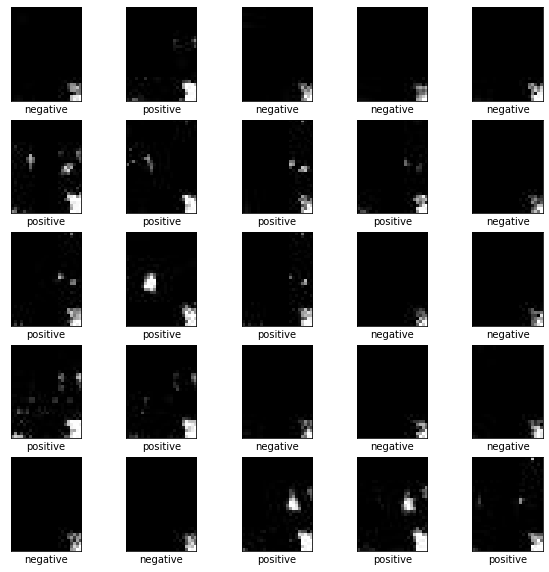

In [20]:
plot_images_grid(images=train_images, labels=train_labels, classes=classes, rows=5, cols=5)


Declare the model
-----------------

* Flatten input
* Layer 1: 60% the number of pixels per image
* Layer 2: 30% the number of pixels per image
* Layer 3: as many neurons as the output labels (in this case 2: negative, positive)

In [21]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_images[0].shape),
    keras.layers.Dense(int(0.6 * train_images.shape[1] * train_images.shape[2]), activation=tf.nn.relu),
    keras.layers.Dense(int(0.3 * train_images.shape[1] * train_images.shape[2]), activation=tf.nn.relu),
    keras.layers.Dense(len(classes), activation=tf.nn.softmax)
])

Compile the model
-----------------

- *Loss function*:This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.
- *Optimizer*: This is how the model is updated based on the data it sees and its loss function.
- *Metrics*: Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [25]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Train the model
---------------

In [26]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1405/1405 [==============================] - 1s 503us/sample - loss: 0.0108 - acc: 0.9972
Epoch 2/5
1405/1405 [==============================] - 1s 414us/sample - loss: 0.0044 - acc: 0.9986
Epoch 3/5
1405/1405 [==============================] - 1s 365us/sample - loss: 0.0284 - acc: 0.9936
Epoch 4/5
1405/1405 [==============================] - 1s 403us/sample - loss: 0.0038 - acc: 0.9986
Epoch 5/5
1405/1405 [==============================] - 1s 378us/sample - loss: 2.5253e-04 - acc: 1.0000


Evaluate accuracy against the test set
--------------------------------------

In [27]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

603/603 [==============================] - 0s 226us/sample - loss: 0.0085 - acc: 0.9967
Test accuracy: 0.99668324


Make predictions on the test set
--------------------------------

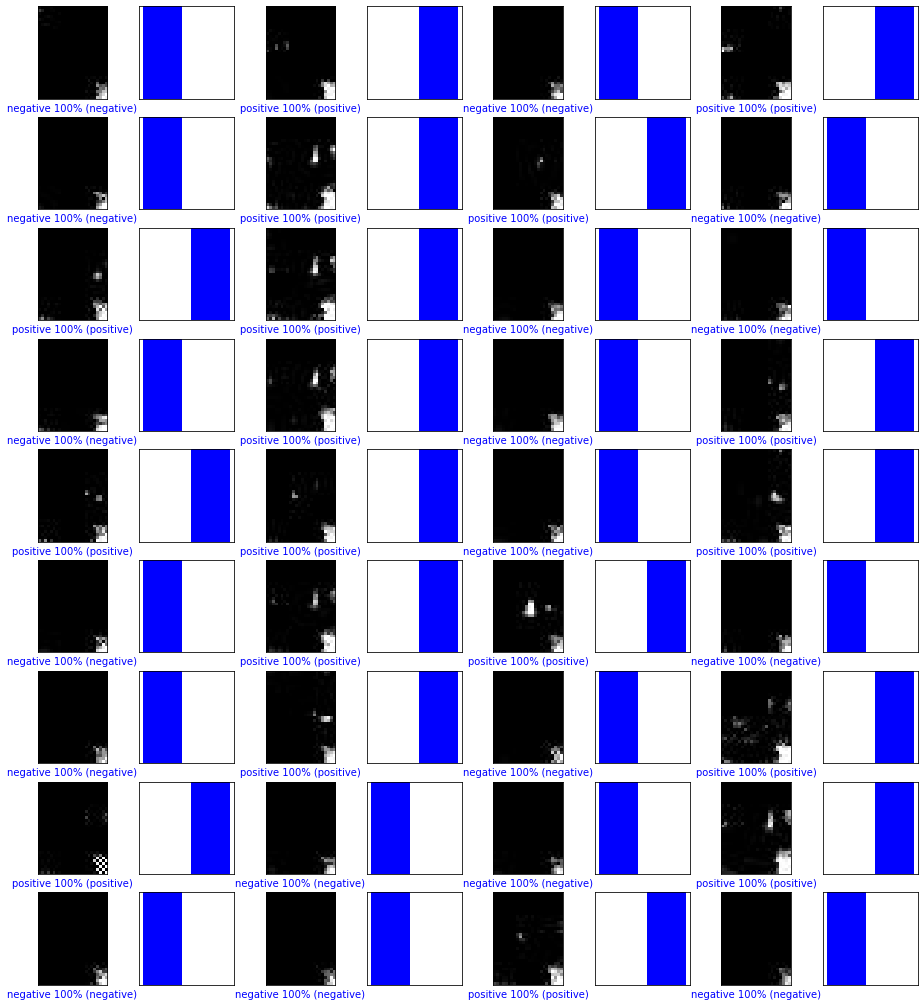

In [28]:
predictions = model.predict(test_images)
plot_results(images=test_images, labels=test_labels, classes=classes, predictions=predictions, rows=9, cols=4)

Export as a Tensorflow model
----------------------------

In [29]:
export_model(model, tf_model_file,
             properties_file=tf_properties_file,
             classes=classes,
             input_size=input_size)

INFO:tensorflow:Froze 75 variables.
INFO:tensorflow:Converted 75 variables to const ops.


INFO:tensorflow:Froze 75 variables.
INFO:tensorflow:Converted 75 variables to const ops.
